In [1]:
import os

import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from tqdm.auto import tqdm

from datasets import get_dataset
from first_order import Ig, Nesterov
from loss_functions import LogisticRegression
from stochastic_first_order import Sgd, Shuffling, ClippedShuffling
from utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

import matplotlib
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

## Get data and set all parameters

In [2]:
dataset = 'covtype'
A, b = get_dataset(dataset)

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness()
l2 = L / np.sqrt(n)
loss.l2 = l2
x0 = csc_matrix((dim, 1))
n_epoch = 600
batch_size = 512
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'results/log_reg_{dataset}_l2_{relative_round(l2)}/'

In [3]:
trace_path

'results/log_reg_covtype_l2_6610.944/'

## Run the methods

In [4]:
nest_str_trace = get_trace(f'{trace_path}nest_str', loss)
if not nest_str_trace:
    nest_str = Nesterov(loss=loss, it_max=n_epoch, mu=l2, strongly_convex=True)
    nest_str_trace = nest_str.run(x0=x0)
    nest_str_trace.compute_loss_of_iterates()
    nest_str_trace.save('nest_str', trace_path)
    nest_str_trace.plot_losses()
    plt.yscale('log')
f_opt = np.min(nest_str_trace.loss_vals)
x_opt = nest_str_trace.xs[-1]

In [5]:
%%time
rr_trace = get_trace(f'{trace_path}rr', loss)
if not rr_trace:
    rr_lr0 = 1 / l2
    rr_decay_coef = l2 / 3
    rr_lr_max = 1 / loss.batch_smoothness(batch_size)
    rr = Shuffling(loss=loss, lr0=rr_lr0, lr_max=rr_lr_max, lr_decay_coef=rr_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, trace_len=trace_len)
    rr_trace = rr.run(x0=x0)
    rr_trace.convert_its_to_epochs(batch_size=batch_size)
    rr_trace.compute_loss_of_iterates()
    rr_trace.save('rr', trace_path)

CPU times: user 12.2 ms, sys: 12.2 ms, total: 24.4 ms
Wall time: 26 ms


Just clipping

In [6]:
c_rr_traces = []
clip_level_list = np.logspace(-1, 2, 4)
for clip_level in tqdm(clip_level_list):
    c_rr_trace = get_trace(f'{trace_path}c_{clip_level}_rr', loss)
    if not c_rr_trace:
        c_rr_lr0 = 1 / l2
        c_rr_decay_coef = l2 / 3
        c_rr_lr_max = 1 / loss.batch_smoothness(batch_size)
        c_rr = ClippedShuffling(
            loss=loss, 
            lr0=c_rr_lr0, 
            lr_max=c_rr_lr_max, 
            lr_decay_coef=c_rr_decay_coef, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level
        )
        c_rr_trace = c_rr.run(x0=x0)
        c_rr_trace.convert_its_to_epochs(batch_size=batch_size)
        c_rr_trace.compute_loss_of_iterates()
        c_rr_trace.compute_last_iterate_grad_norms()
        c_rr_trace.save(f'c_{clip_level}_rr', trace_path)
    c_rr_traces.append(c_rr_trace)

  0%|          | 0/4 [00:00<?, ?it/s]

Clipping with gradient at opt

In [7]:
c_rr_opt_traces = []
for clip_level in tqdm(clip_level_list):
    c_rr_opt_trace = get_trace(f'{trace_path}c_{clip_level}_opt_rr', loss)
    if not c_rr_opt_trace:
        c_rr_opt_lr0 = 1 / l2
        c_rr_opt_decay_coef = l2 / 3
        c_rr_opt_lr_max = 1 / loss.batch_smoothness(batch_size)
        c_rr_opt = ClippedShuffling(
            loss=loss, 
            lr0=c_rr_opt_lr0, 
            lr_max=c_rr_opt_lr_max, 
            lr_decay_coef=c_rr_opt_decay_coef, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level,
            x_opt=x_opt
        )
        c_rr_opt_trace = c_rr_opt.run(x0=x0)
        c_rr_opt_trace.convert_its_to_epochs(batch_size=batch_size)
        c_rr_opt_trace.compute_loss_of_iterates()
        c_rr_opt_trace.compute_last_iterate_grad_norms()
        c_rr_opt_trace.save(f'c_{clip_level}_opt_rr', trace_path)
    c_rr_opt_traces.append(c_rr_opt_trace)

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
c_rr_opt_lr0 = 1 / l2
c_rr_opt_decay_coef = l2 / 3
c_rr_opt_lr_max = 1 / loss.batch_smoothness(batch_size)
c_rr_opt = ClippedShuffling(
    loss=loss, 
    lr0=c_rr_opt_lr0, 
    lr_max=c_rr_opt_lr_max, 
    lr_decay_coef=c_rr_opt_decay_coef, 
    it_max=stoch_it, 
    n_seeds=n_seeds, 
    batch_size=batch_size, 
    trace_len=trace_len,
    clip_level=clip_level,
    x_opt=x_opt
)

In [11]:
so_trace = get_trace(f'{trace_path}so', loss)
if not so_trace:
    so_lr0 = 1 / l2
    so_decay_coef = l2 / 3
    so_lr_max = 1 / loss.batch_smoothness(batch_size)
    so = Shuffling(loss=loss, lr0=so_lr0, lr_max=so_lr_max, lr_decay_coef=so_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, steps_per_permutation=np.inf, trace_len=trace_len)
    so_trace = so.run(x0=x0)
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_trace.save('so', trace_path)

In [12]:
sgd_trace = get_trace(f'{trace_path}sgd_no_miss', loss)
sgd_perm = np.random.permutation(n)
loss_sgd = LogisticRegression(A[sgd_perm], b[sgd_perm], l1=0, l2=l2)
if not sgd_trace:
    sgd_lr0 = 1 / l2
    sgd_decay_coef = l2 / 2
    sgd_lr_max = 1 / loss.batch_smoothness(batch_size)
    sgd = Sgd(loss=loss_sgd, lr_max=sgd_lr_max, lr0=sgd_lr0, lr_decay_coef=sgd_decay_coef, 
              it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, avoid_cache_miss=True, trace_len=trace_len)
    sgd_trace = sgd.run(x0=x0)
    sgd_trace.convert_its_to_epochs(batch_size=batch_size)
    sgd_trace.compute_loss_of_iterates()
    sgd_trace.save('sgd_no_miss', trace_path)

In [13]:
ig_trace = get_trace(f'{trace_path}ig', loss)
if not ig_trace:
    ig_lr0 = 1 / l2
    ig_decay_coef = l2 / 3
    ig_lr_max = 1 / loss.batch_smoothness(batch_size)
    ig = Ig(loss=loss, lr0=ig_lr0, lr_max=ig_lr_max, lr_decay_coef=ig_decay_coef, it_max=stoch_it, 
            batch_size=batch_size, trace_len=trace_len)
    ig_trace = ig.run(x0=x0)
    ig_trace.convert_its_to_epochs(batch_size=batch_size)
    ig_trace.compute_loss_of_iterates()
    ig_trace.save('ig', trace_path)

# Performance plots

## Functional residual

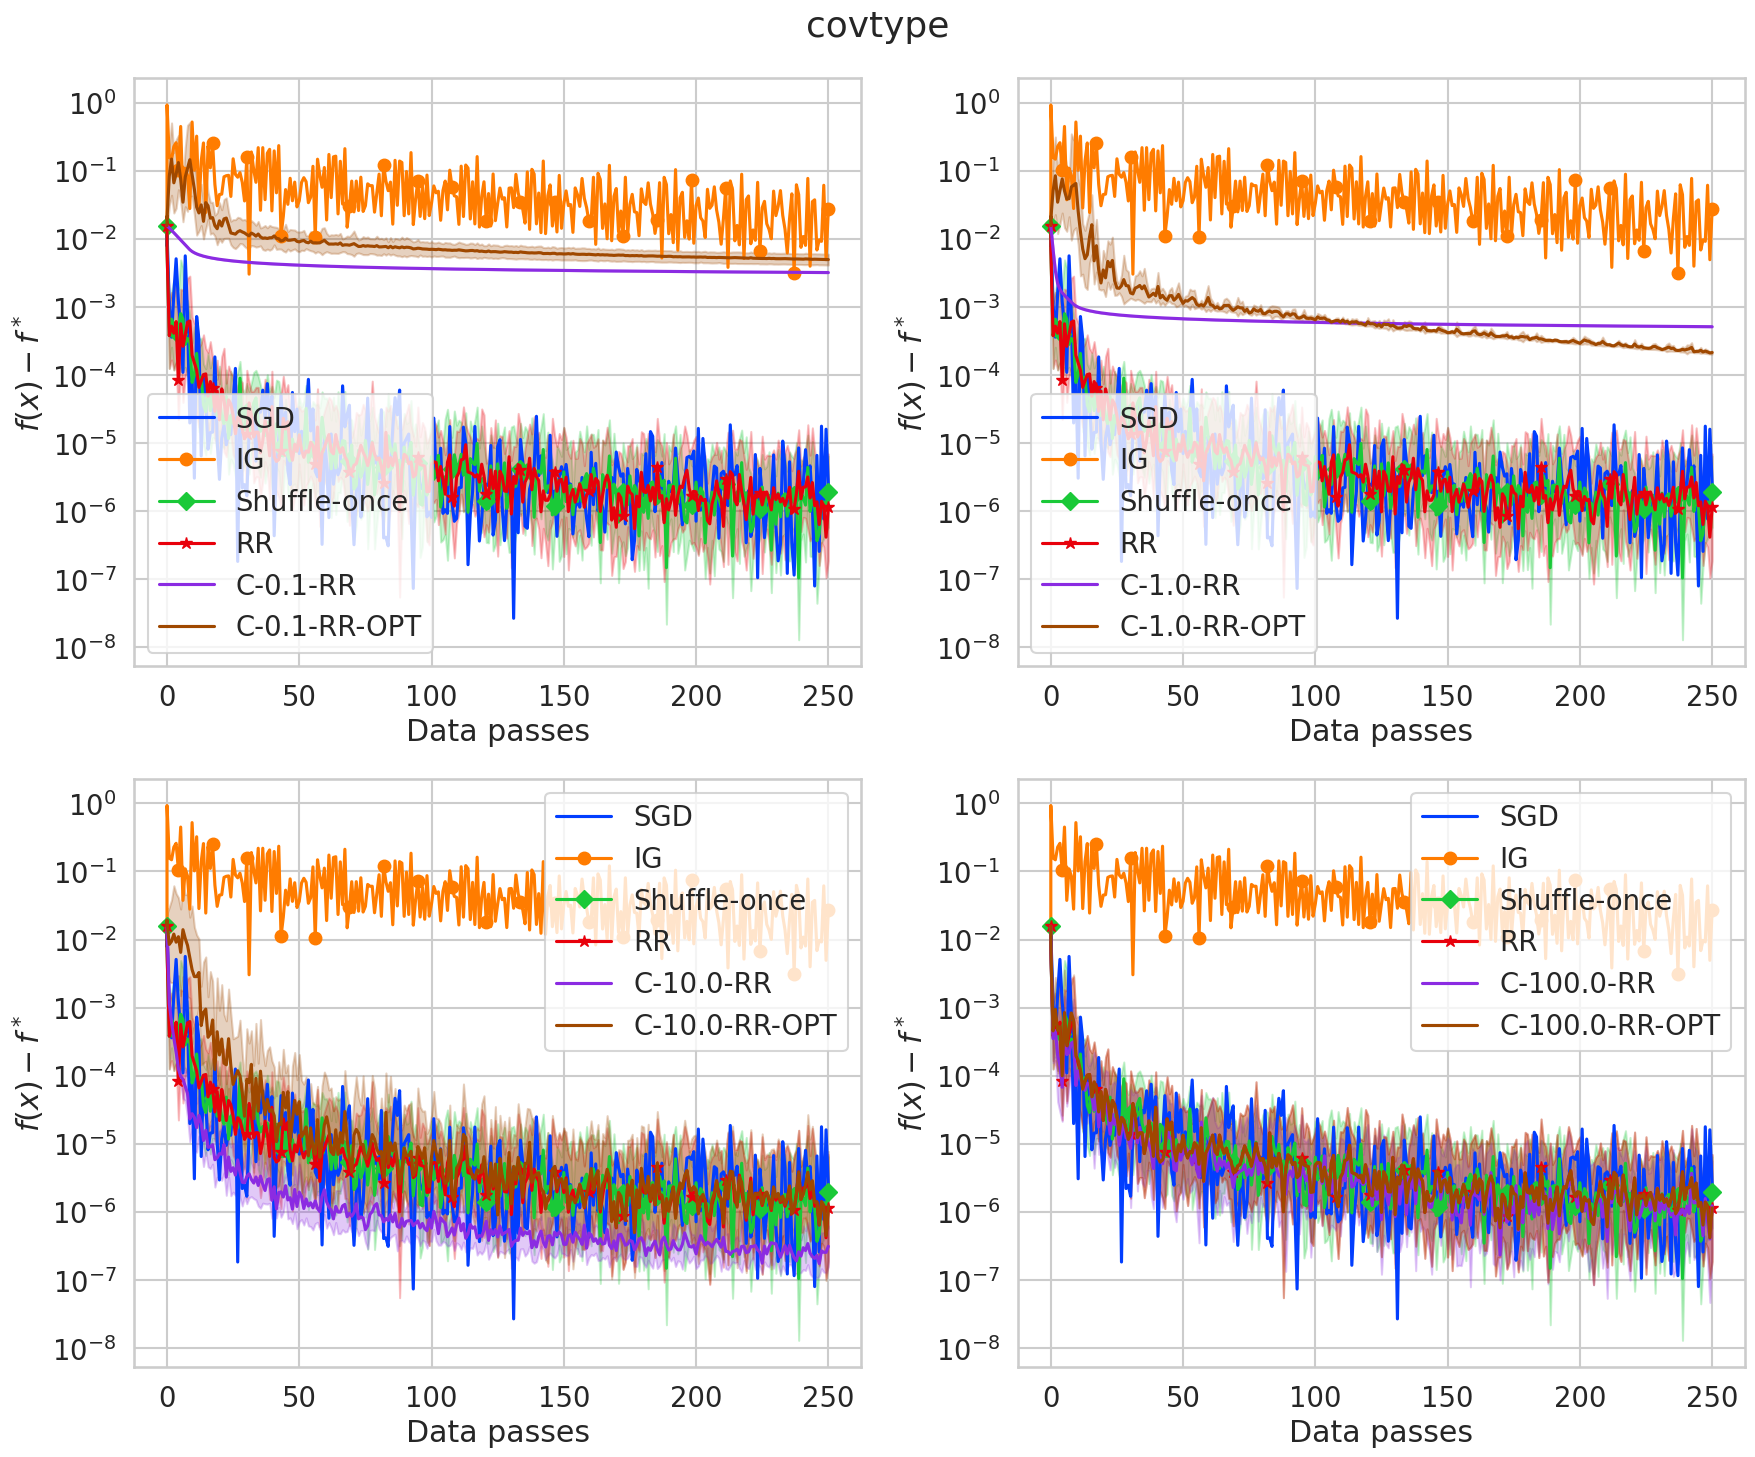

In [14]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_func.png', dpi=300)

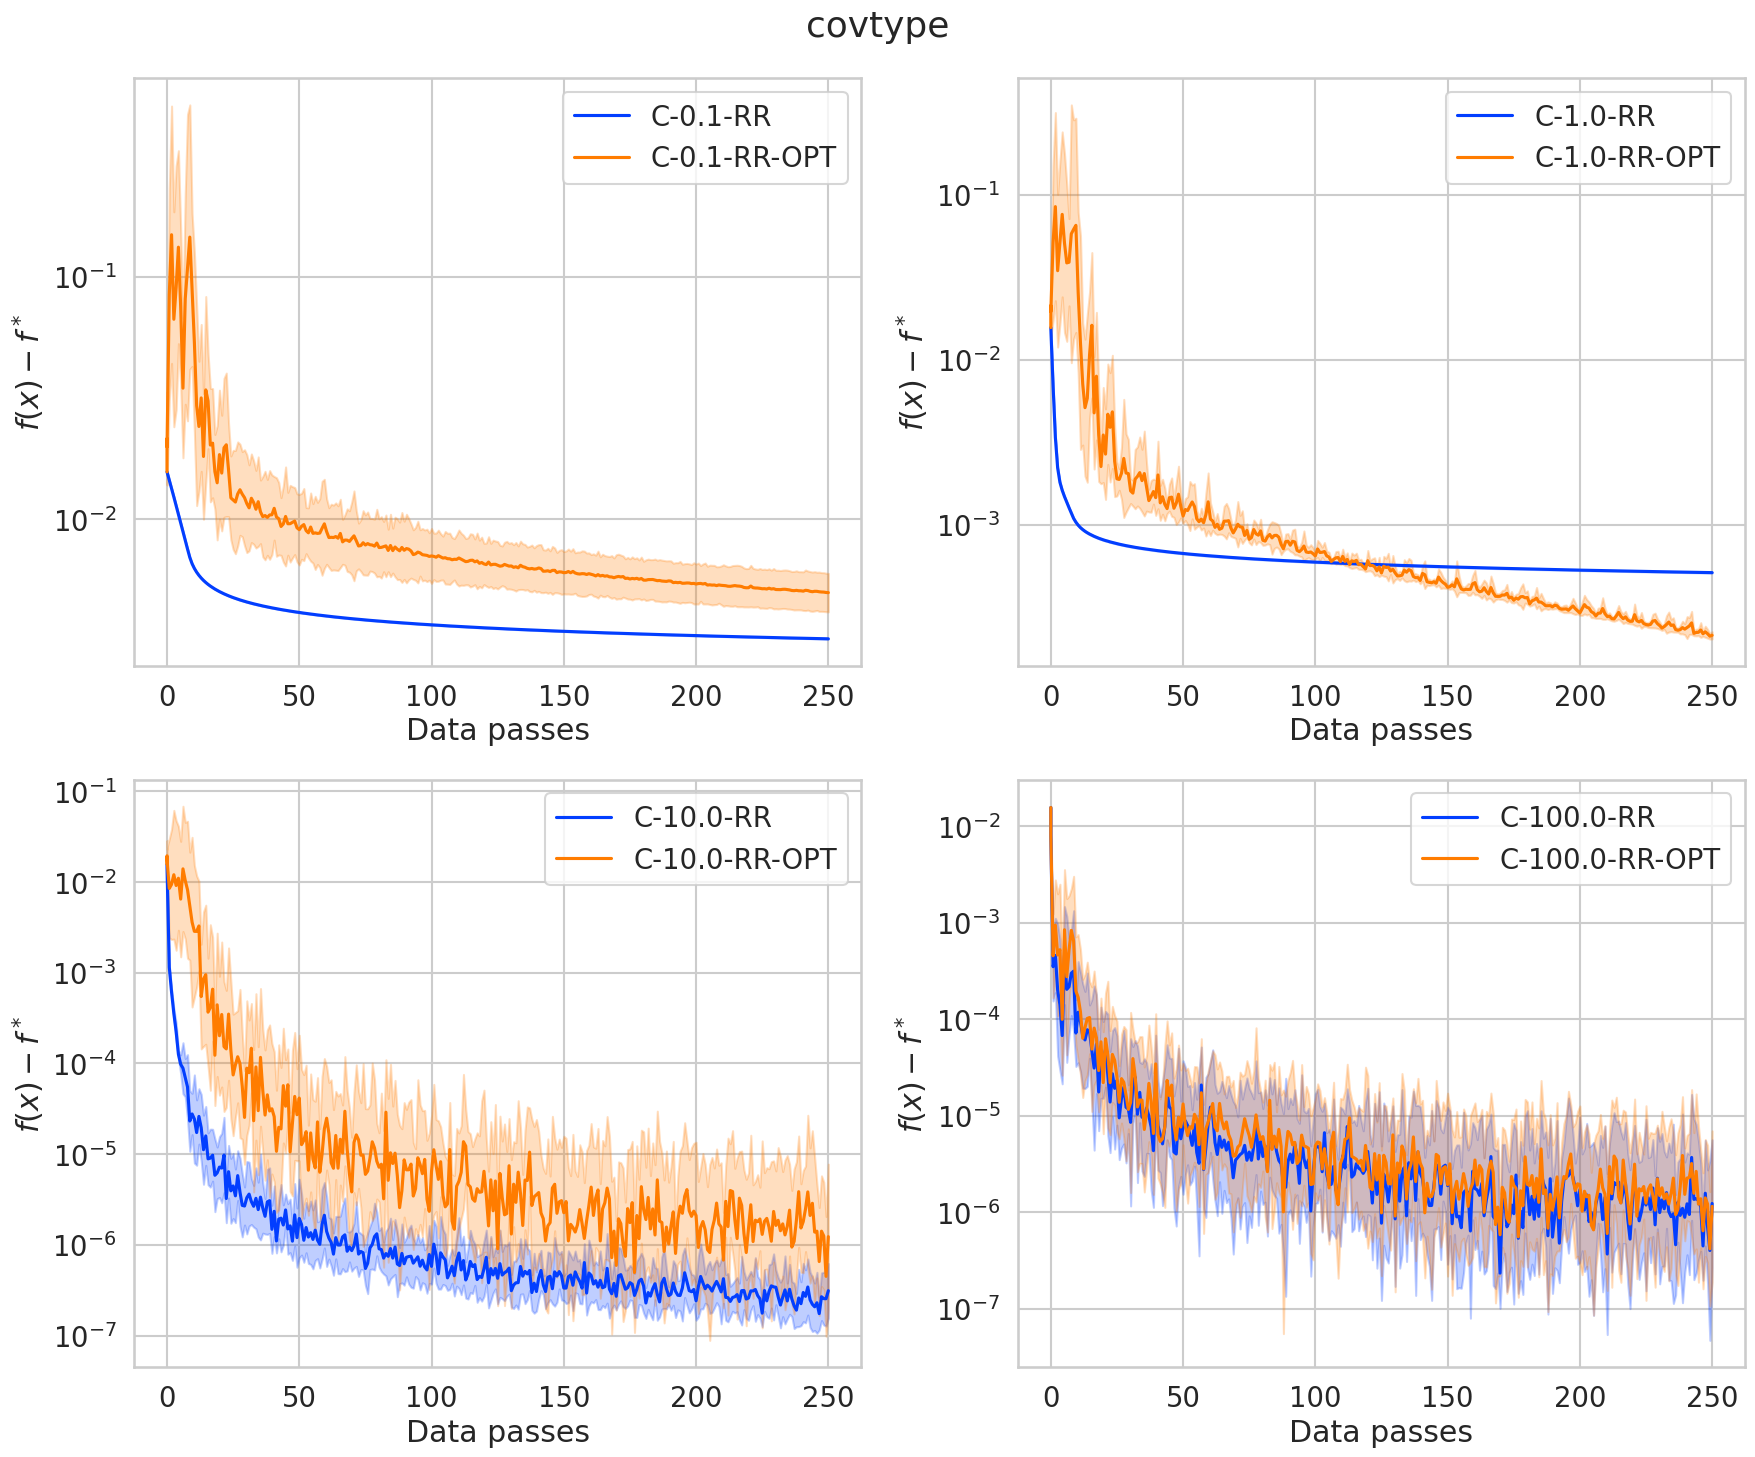

In [15]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_func_ez.png', dpi=300)

# Distance to solution

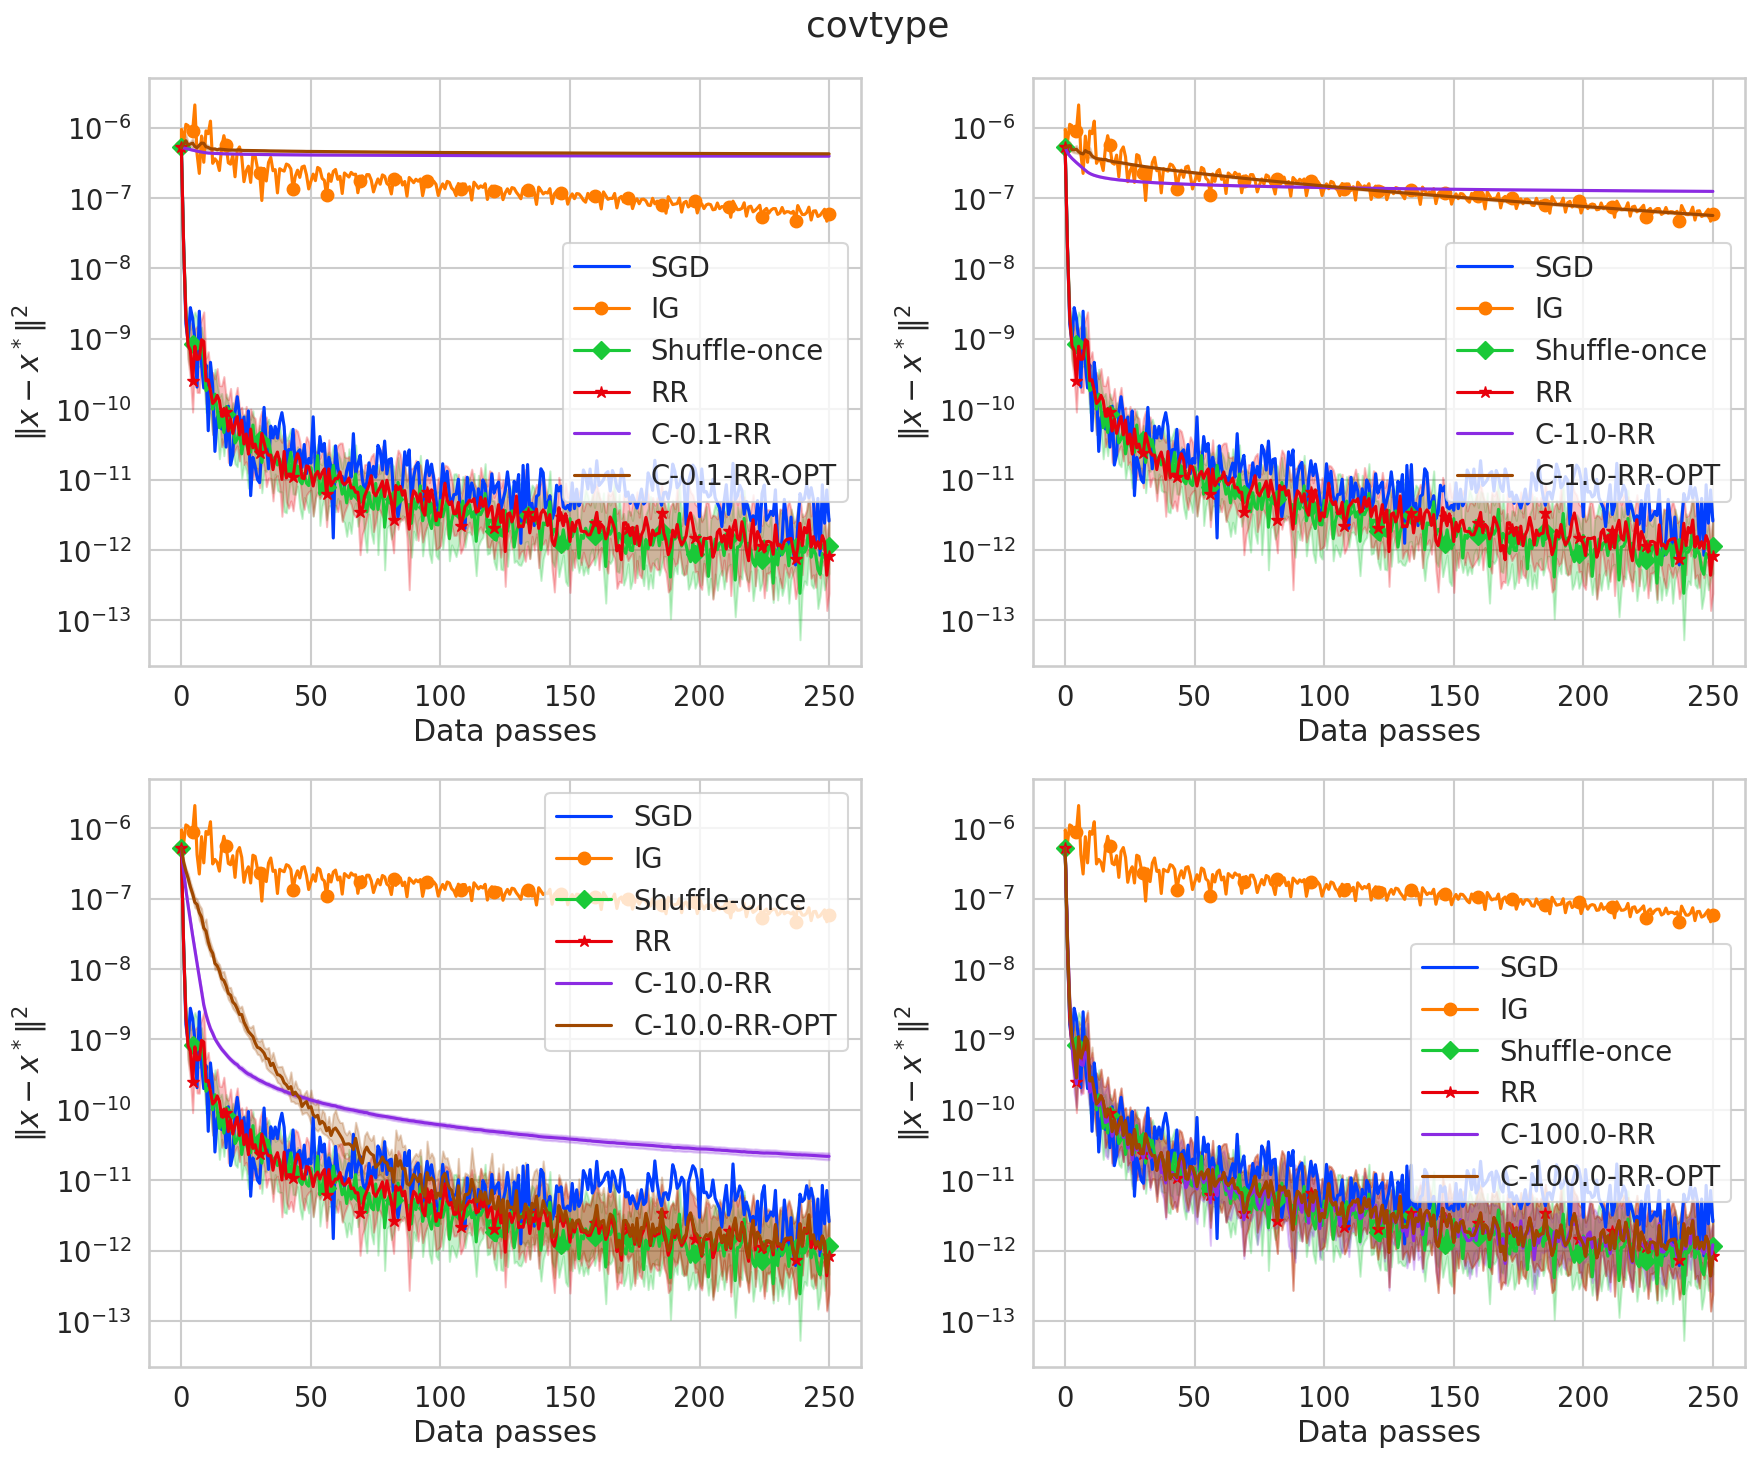

In [16]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_dist.png', dpi=300)

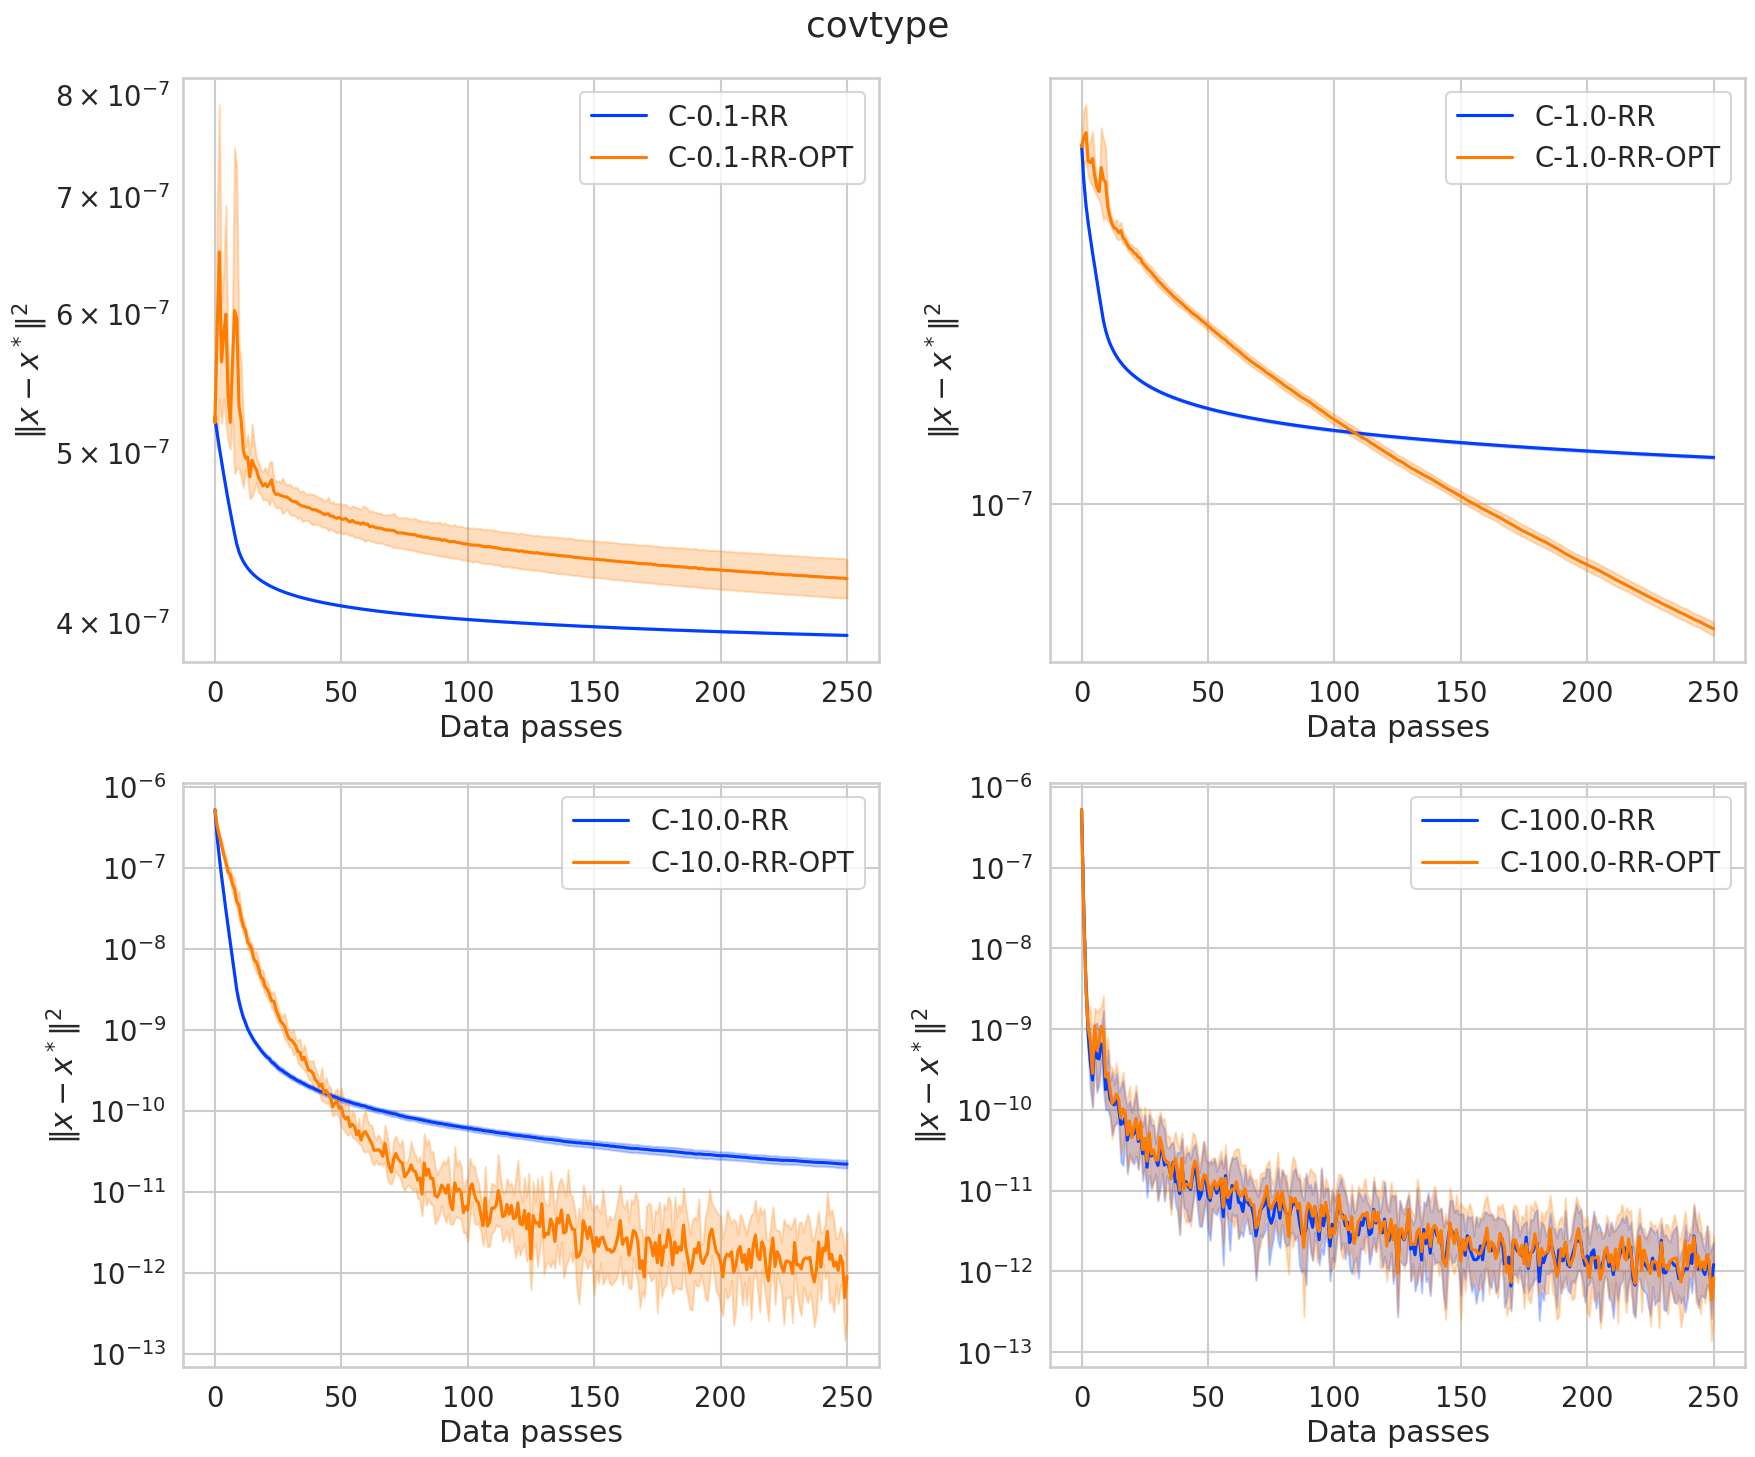

In [17]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_dist_ez.png', dpi=300)

# Histogram of gradient value in the last point

In [ ]:
colors = sns.color_palette('coolwarm', len(patches))

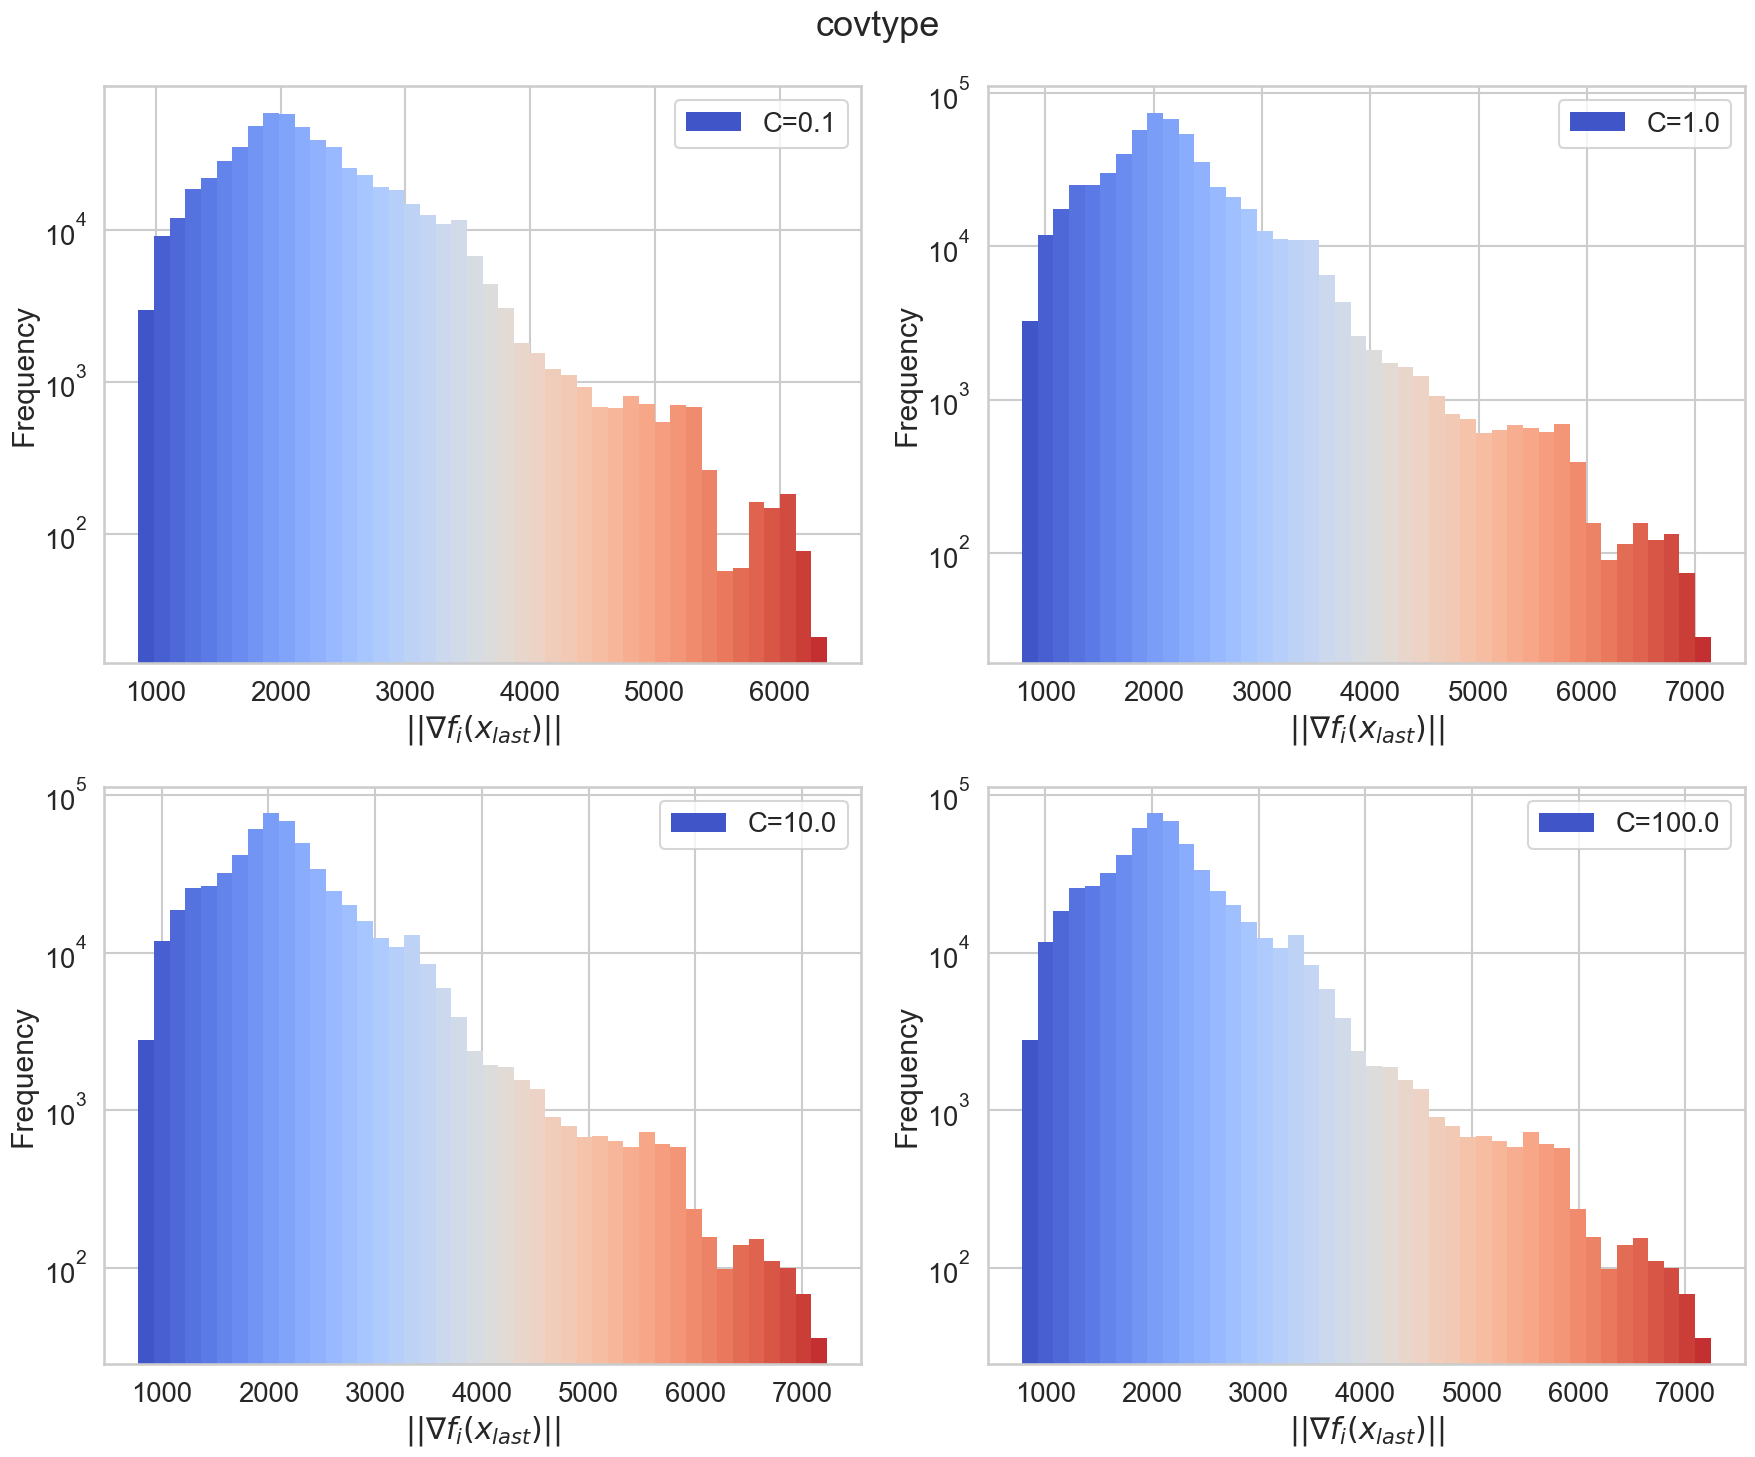

In [84]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
for ax, c_rr_trace, clip_level in zip(axis.flatten(), c_rr_traces, clip_level_list):
    grad_norms = list(c_rr_trace.grad_norms_last_iterate.values())[0]
    # bins = np.logspace(np.log10(np.min(grad_norms)), np.log10(np.max(grad_norms)), 45)
    bins = np.linspace(np.min(grad_norms), np.max(grad_norms), 45)
    colors = sns.color_palette('coolwarm', len(bins))
    freq, bins, patches = ax.hist(
        list(c_rr_trace.grad_norms_last_iterate.values())[0], 
        bins=bins, 
        edgecolor='#e0e0e0', 
        linewidth=0., 
        log=True, 
        label=f'C={clip_level}'
    )
    freq = freq.astype('int')
    for i in range(len(patches)):
        patches[i].set_facecolor(colors[i])
    # ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel(r'$||\nabla f_i(x_{last})||$')
    ax.set_ylabel('Frequency')
    ax.minorticks_on()
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_g_norm_hist.png', dpi=300)